In [1]:
%matplotlib notebook
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import torch
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
# import sys
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4748527699303568861
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11982094336
locality {
  bus_id: 2
}
incarnation: 14433910272238709250
physical_device_desc: "device: 0, name: Graphics Device, pci bus id: 0000:82:00.0, compute capability: 6.1"
]


In [2]:
r=8
w1=np.zeros((21,21))
x1=np.array([np.arange(21)]).T
x2=np.array([np.arange(21)])
X1, X2=np.meshgrid(x1,x2)
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w1[x1c, x2c]=1
# plt.figure()
# plt.imshow(w1)
# plt.close()
r=6
w2=np.zeros((21,21))
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w2[x1c, x2c]=1
# plt.figure()
# plt.imshow(w2)
# plt.close()
r=8
w3=np.zeros((21,21))
w3[2*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[18*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[2:19 ,2*np.ones((1,17),dtype=np.int8)]=1
w3[2:19 ,18*np.ones((1,17),dtype=np.int8)]=1
# plt.imshow(w3)
r=6
w4=np.zeros((21,21))
w4[4*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[16*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[4:17, 4*np.ones((1,13),dtype=np.int8)]=1
w4[4:17, 16*np.ones((1,13),dtype=np.int8)]=1
# plt.imshow(w4)
w5=np.zeros((21,21))
w5[[8,8], [8,12]]=1;
# plt.imshow(w5)
w6=np.zeros((21,21))
w6[9:11, [10,10]]=1;
# plt.imshow(w6)
w7=np.zeros((21,21))
w7[[13,14,14,14,13], [8,9,10,11,12]]=1;
# plt.imshow(w7)
w8=np.zeros((21,21))
w8[[14,13,13,13,14], [8,9,10,11,12]]=1;
# plt.imshow(w7)
# plt.imshow(w1+w5+w6+w8)
# w1, w2, w3, w4
# w5, w6
# w7
# w8
X=np.zeros((8,21*21))
X[0,:]=(w1+w5+w6+w7).reshape((1,21*21))
X[1,:]=(w2+w5+w6+w7).reshape((1,21*21))
X[2,:]=(w3+w5+w6+w7).reshape((1,21*21))
X[3,:]=(w4+w5+w6+w7).reshape((1,21*21))
X[4,:]=(w1+w5+w6+w8).reshape((1,21*21))
X[5,:]=(w2+w5+w6+w8).reshape((1,21*21))
X[6,:]=(w3+w5+w6+w8).reshape((1,21*21))
X[7,:]=(w4+w5+w6+w8).reshape((1,21*21))
X=X.T

W=np.zeros((8,21*21))
W[0,:]=w1.reshape((1,21*21))
W[1,:]=w2.reshape((1,21*21))
W[2,:]=w3.reshape((1,21*21))
W[3,:]=w4.reshape((1,21*21))
W[4,:]=w5.reshape((1,21*21))
W[5,:]=w6.reshape((1,21*21))
W[6,:]=w7.reshape((1,21*21))
W[7,:]=w8.reshape((1,21*21))
W=W.T

In [3]:
# Sparse Coding Adam, nonlinearity

lr=0.001
Y=Variable(torch.cuda.FloatTensor([[1,1,1,1,0,0,0,0], [0,0,0,0,1,1,1,1]]), requires_grad=False)
x=Variable(torch.cuda.FloatTensor(X), requires_grad=False)
We=Variable((torch.randn(8,21*21).type(torch.cuda.FloatTensor)-.5)*.001, requires_grad=True)
be=Variable((torch.randn(8,1).type(torch.cuda.FloatTensor)-.5)*.001, requires_grad=True)
W2=Variable((torch.randn(2,8).type(torch.cuda.FloatTensor)-.5)*.001, requires_grad=True)
b2=Variable((torch.randn(2,1).type(torch.cuda.FloatTensor)-.5)*.001, requires_grad=True)

maxIter=300
errt=np.zeros(maxIter, dtype=np.float32)

selu=torch.nn.SELU()

optimizer = torch.optim.Adam([We, W2, be, b2], betas=[0.9, 0.999], lr=lr)

for i in range(maxIter):
    Yh=W2@selu(We@x+be)+b2
    err=torch.sum(-Y*torch.log(torch.exp(Yh)/torch.sum(torch.exp(Yh), dim=0, keepdim=True)))
    errt[i]=err.data
    
    optimizer.zero_grad()   
    err.backward()
#     W2.data=W2.data-lr*W2.grad.data
#     We.data=We.data-lr*We.grad.data
#     b2.data=b2.data-lr*b2.grad.data
#     be.data=be.data-lr*be.grad.data
    
    optimizer.step()    

    
    



<IPython.core.display.Javascript object>


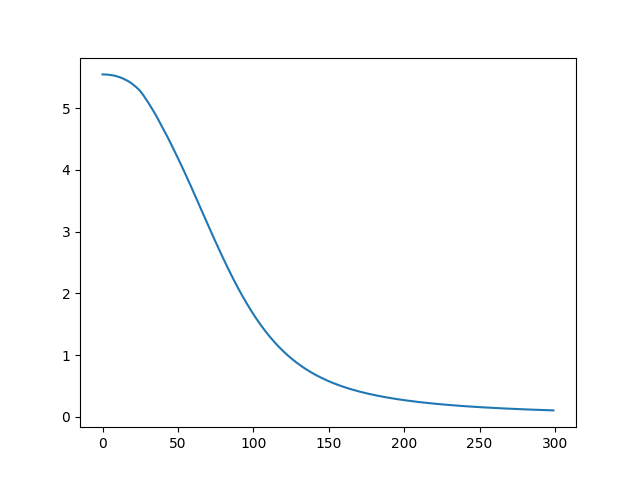

<IPython.core.display.Javascript object>


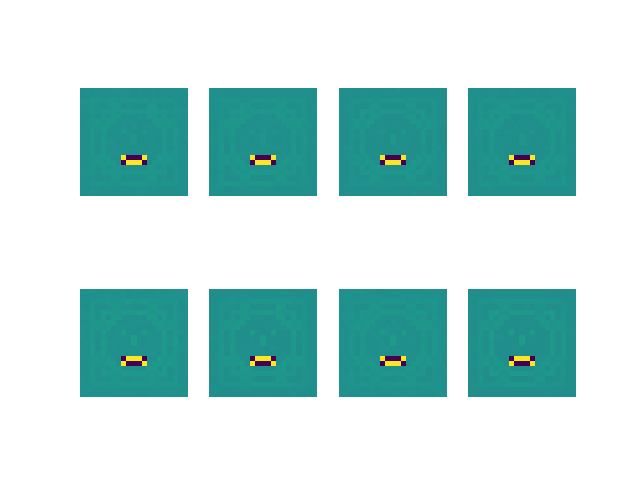

In [4]:
plt.figure()
plt.plot(errt)
plt.show()
plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(We.data[i,:].resize_((21,21)))
    plt.axis('off')
    plt.show()